In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 


In [14]:
registeredUsers = pd.read_csv('registration1d.csv', delimiter = ';', index_col = ['date'], parse_dates = ['date'])

In [43]:
registeredUsers.head()

,registeredUsers
date,
2019-01-01,990
2019-01-02,1081
2019-01-03,947
2019-01-04,847
2019-01-05,821


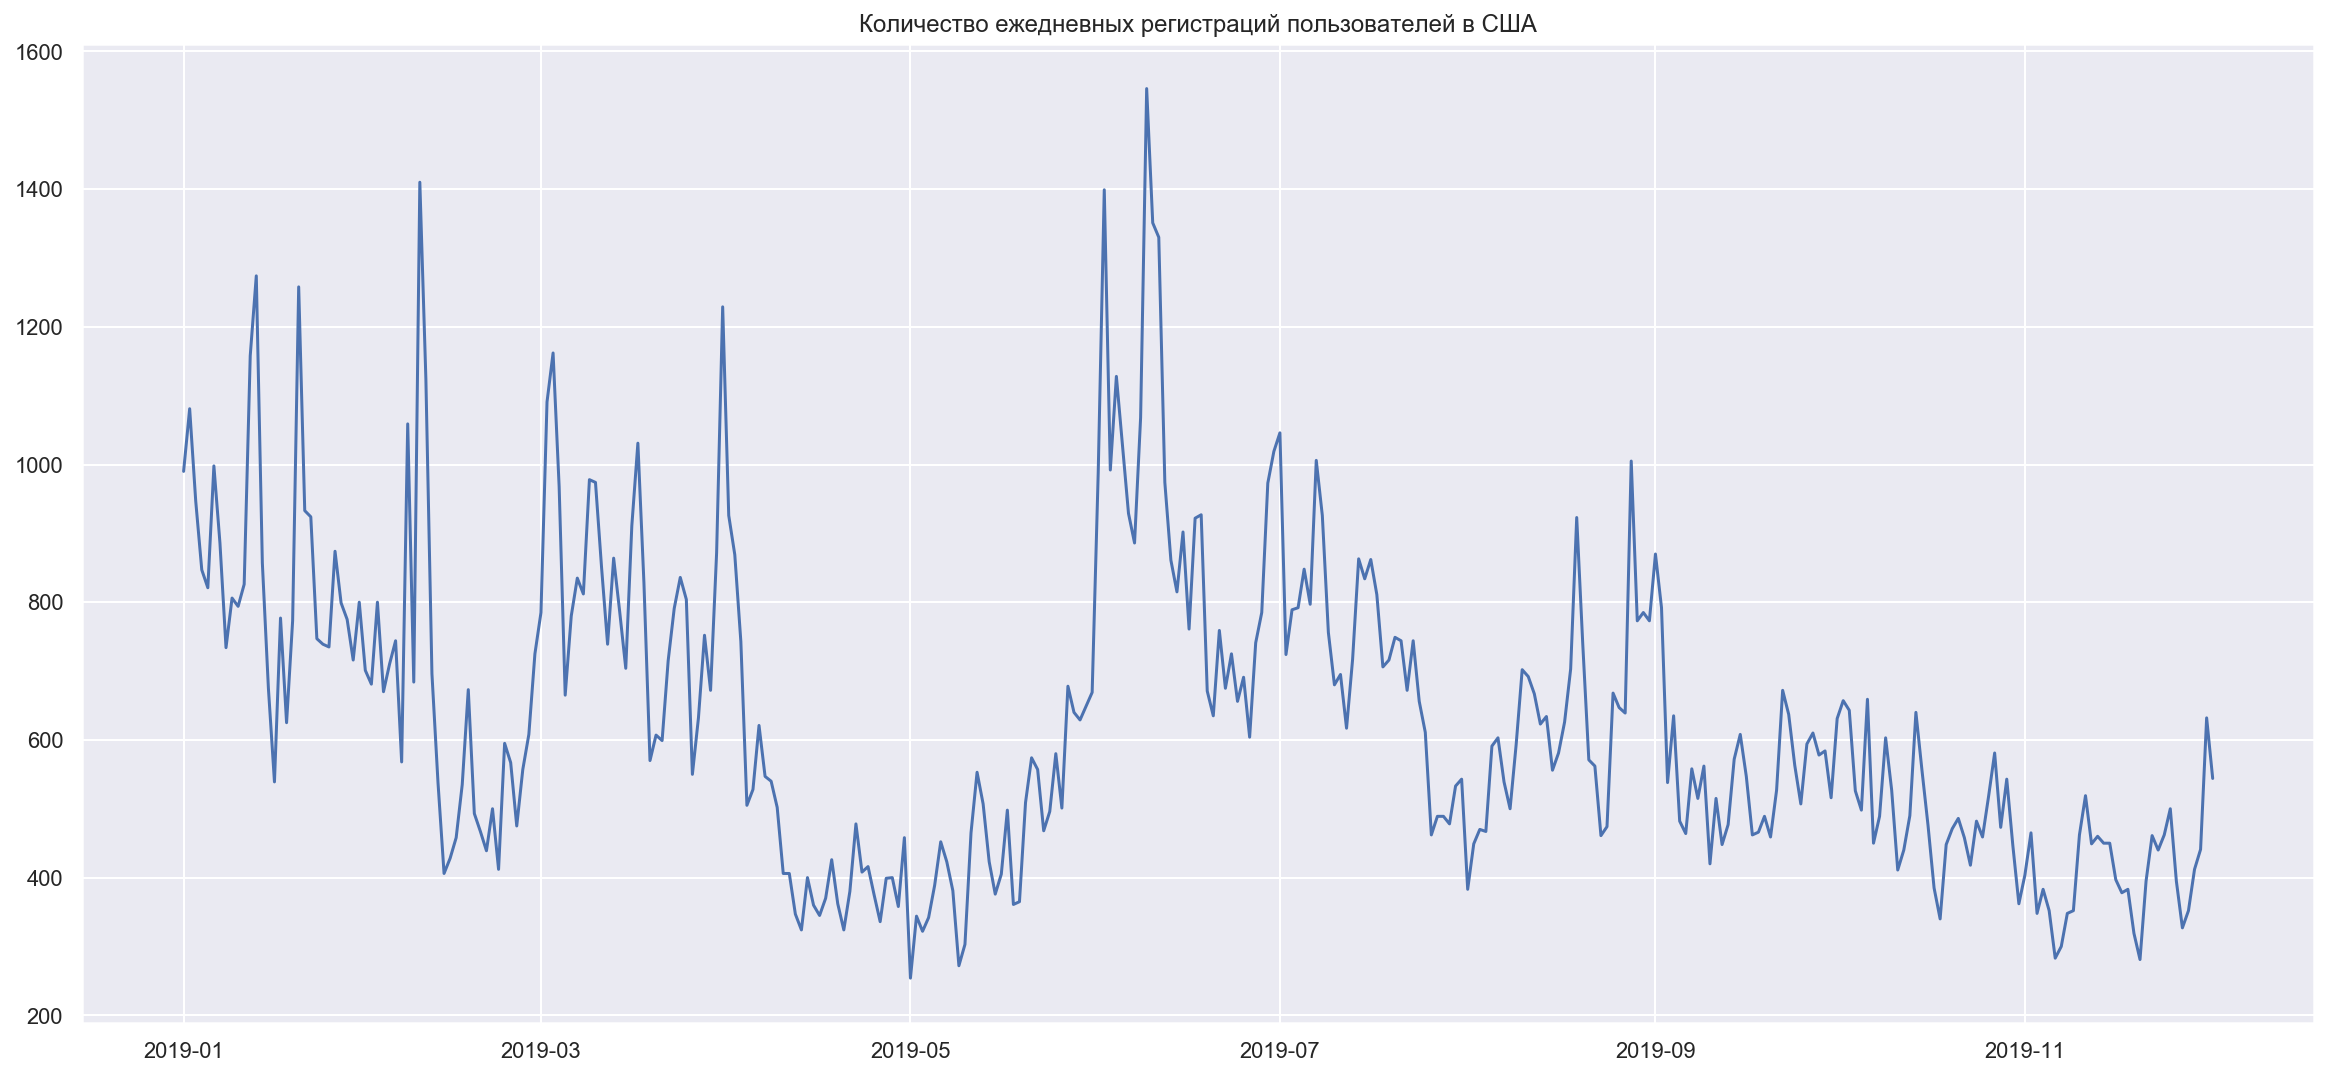

In [15]:
plt.figure(figsize = (20, 9))
plt.plot(registeredUsers)
plt.title('Количество ежедневных регистраций пользователей в США')
plt.grid(True)
plt.show();

In [6]:
# Метрики ошибок модели
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
# Скользящая средняя
def moving_average(series, n):
    '''
        Расчет скользящей средней на основе n 
        предыдущих значений временного ряда T
    '''
    return np.average(series[-n:])

In [16]:
# Предскаазние для последнего наблюдаемого дня (за последние 24 часа)
moving_average(registeredUsers, 24) # actual value 463

427.5416666666667

In [17]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with time series
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window = window).mean()
    
    plt.figure(figsize=(20,10))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label = 'Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
        #Having confidence intervals for smoothed value
        if plot_anomalies:
            anomalies = pd.DataFrame(index = series.index, columns = series.columns)
            anomalies[series < lower_bound] = series[series < lower_bound]
            anomalies[series > upper_bound] = series[series > upper_bound]
            plt.plot(anomalies, 'ro', markersize=10)
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='upper left')
    plt.grid(True)

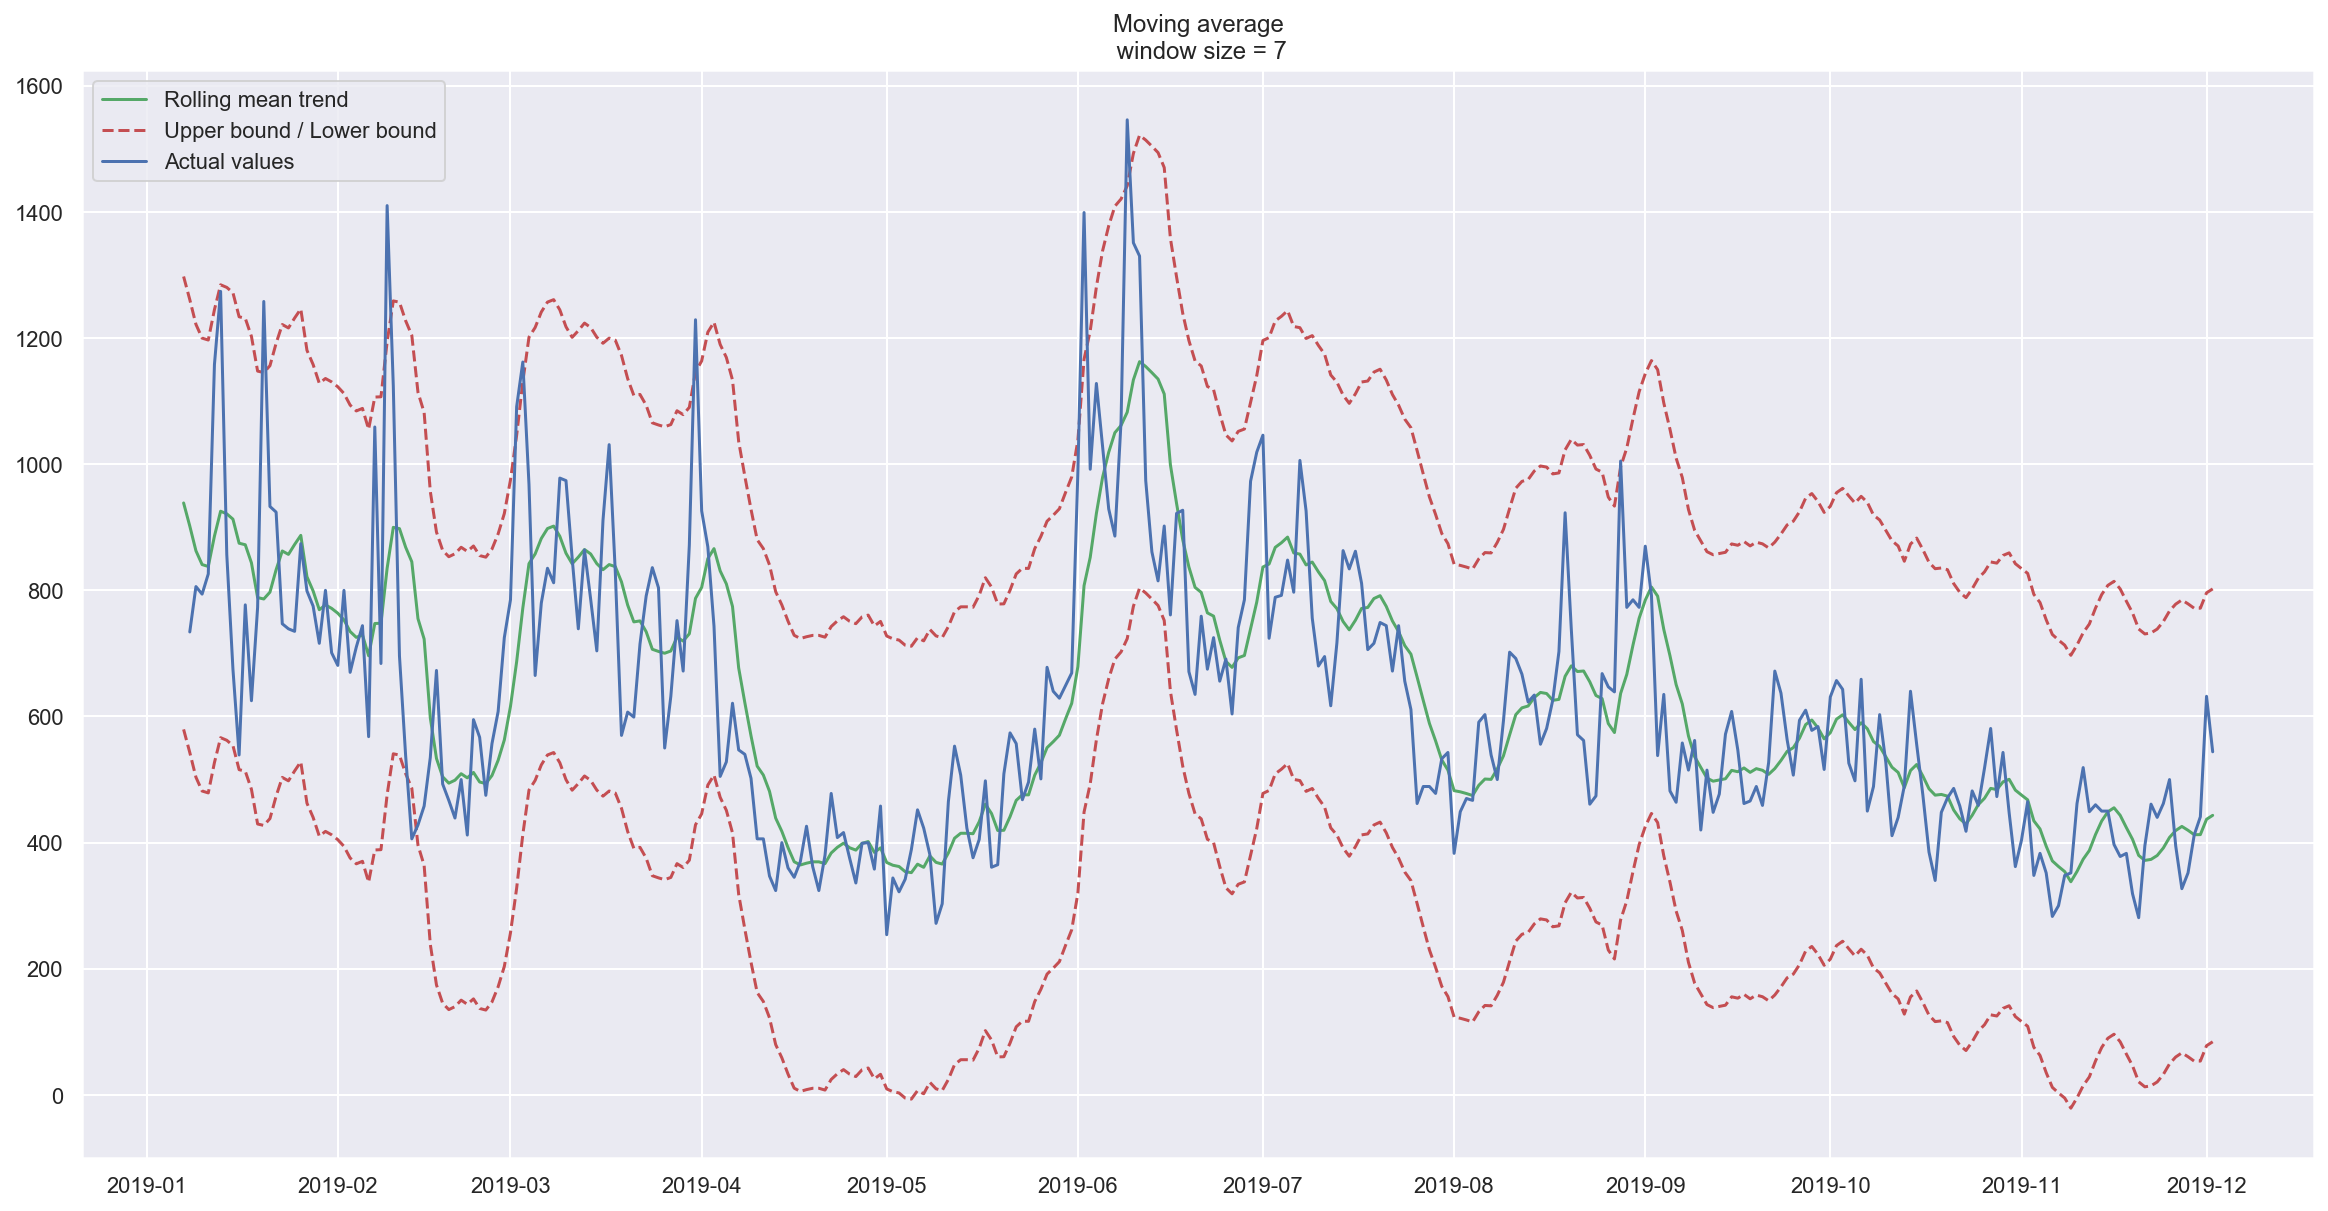

In [19]:
# Cглаживание за 7 последних дней
plot_moving_average(registeredUsers, 7, plot_intervals = True)

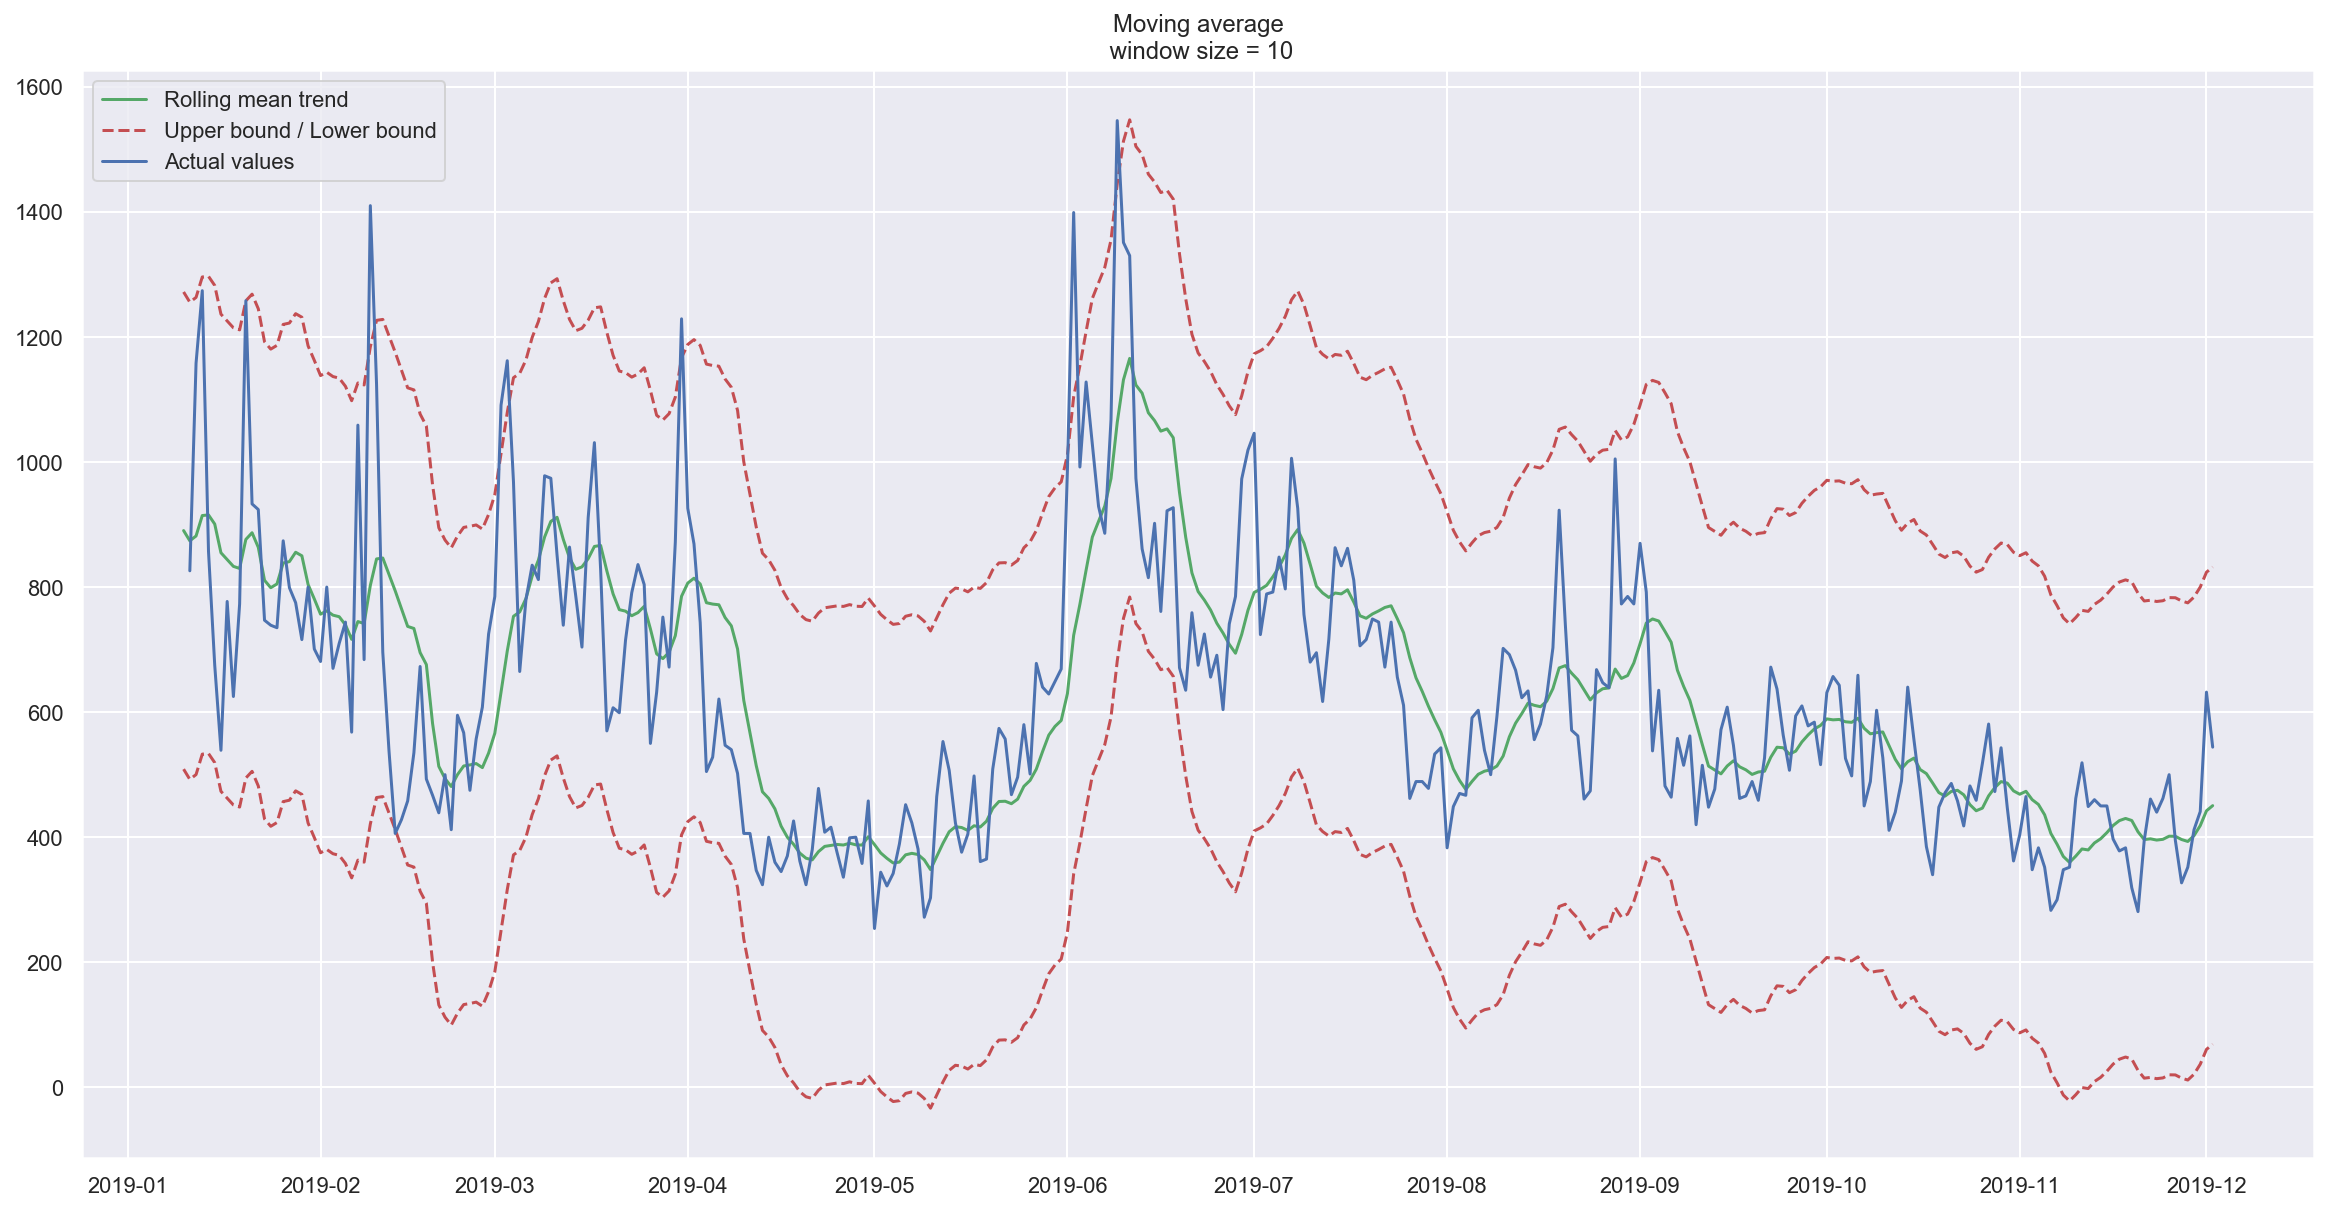

In [22]:
# Сглаживание за последние 10 дней
plot_moving_average(registeredUsers, 10, plot_intervals = True)

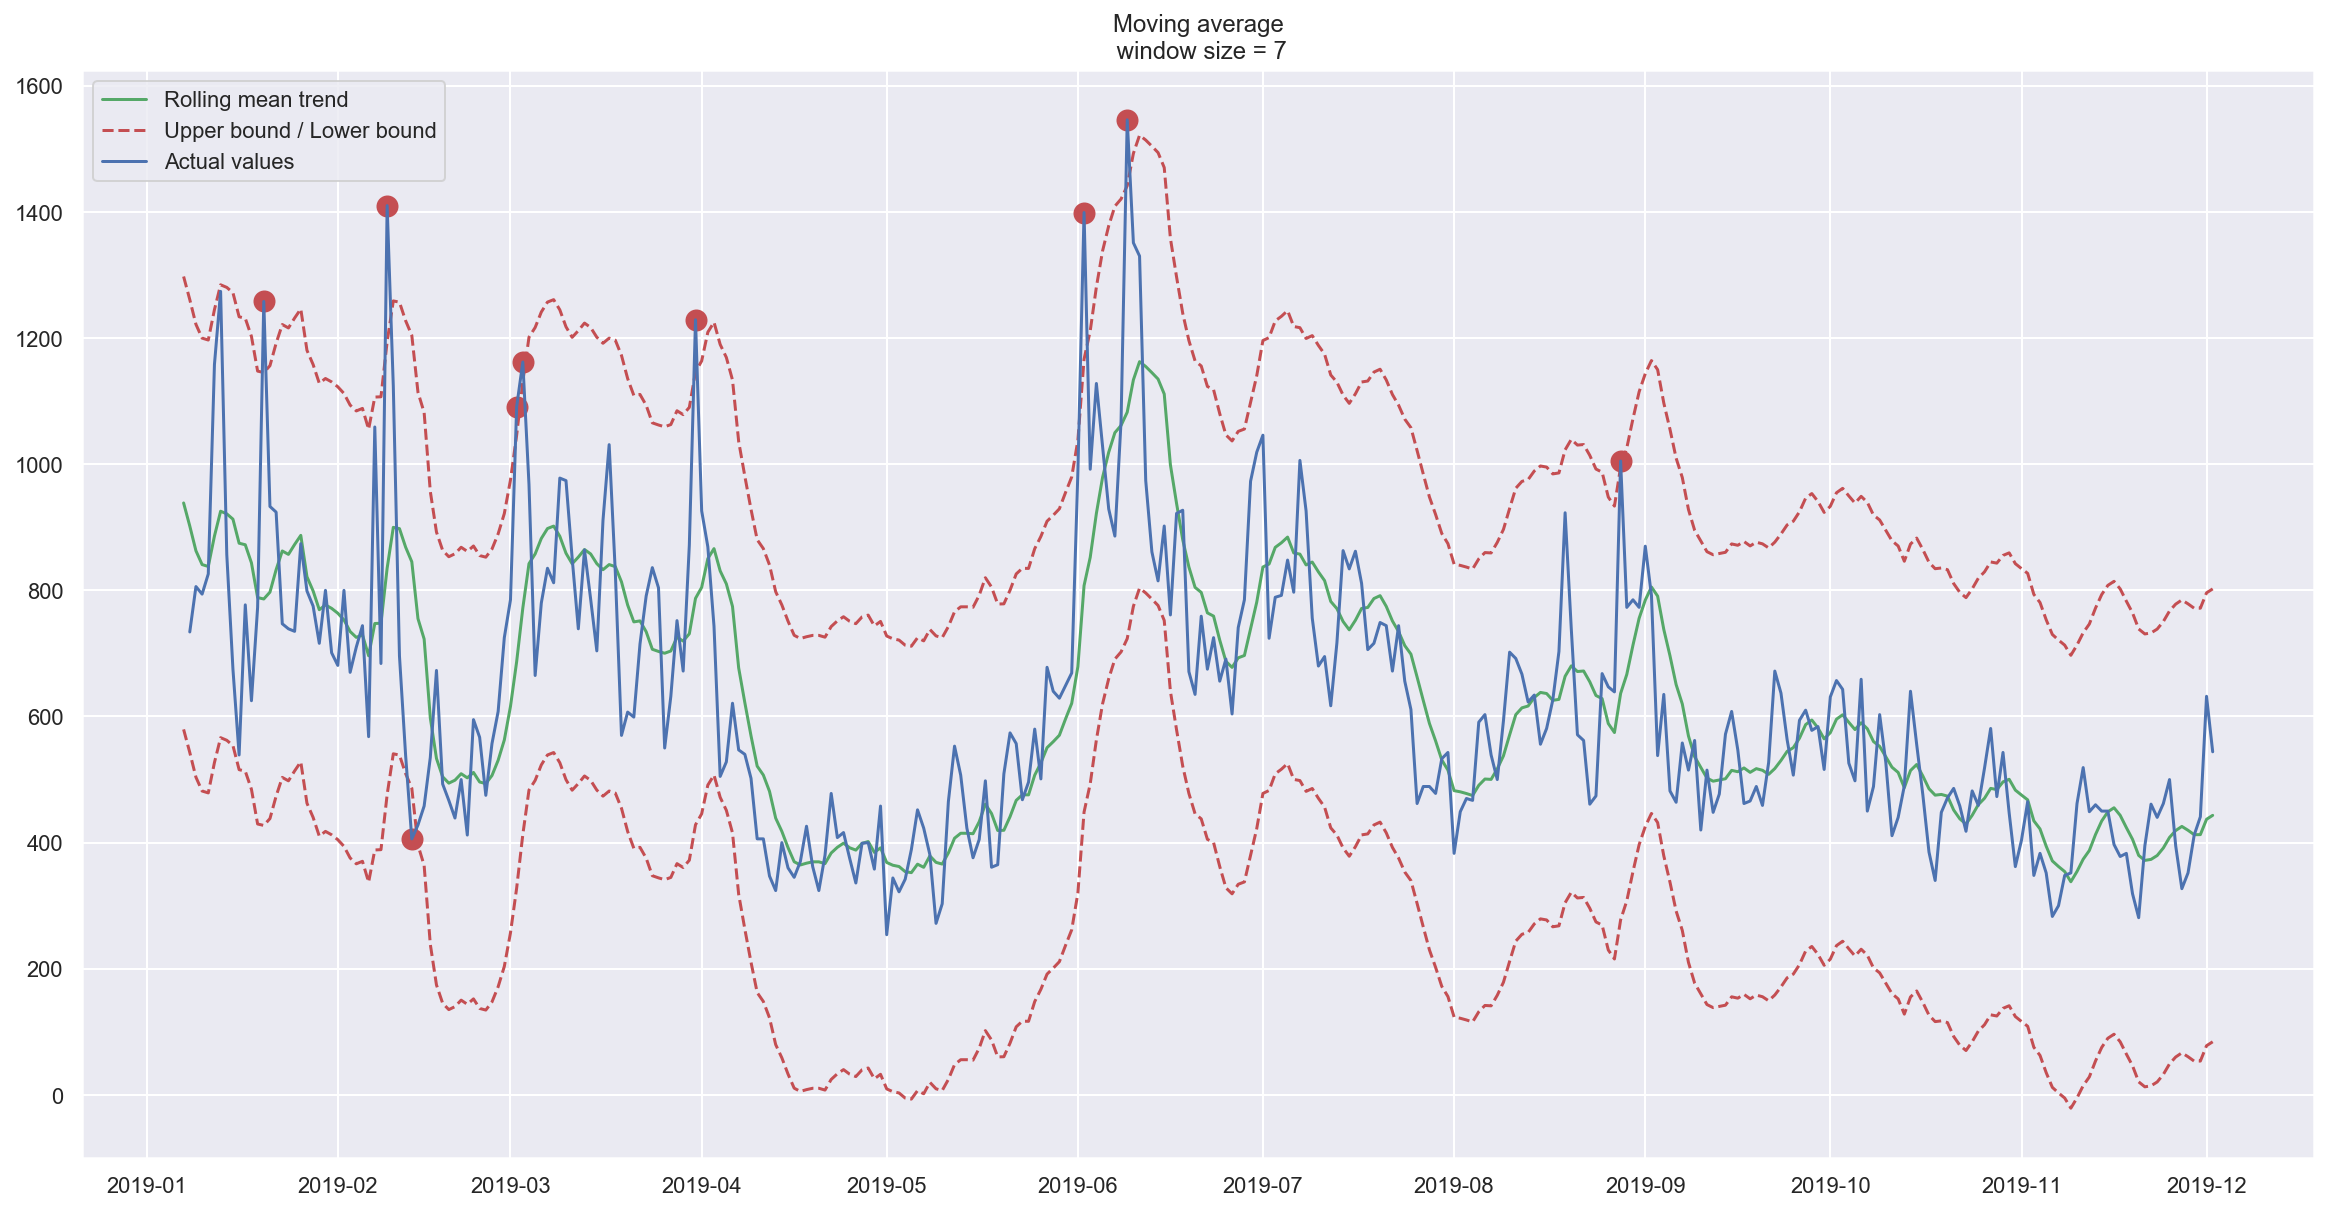

In [38]:
registeredUsers_anomaly = registeredUsers.copy(deep = True) 

plot_moving_average(registeredUsers_anomaly, 7, plot_intervals = True, plot_anomalies = True)

In [39]:
# Weighted average. The weights sum up to 1 woth larger weights assigned to more recent observations
def weighted_average(series, weights):
    '''
       Расчет средневзвешенной величины на основе
       наблюдаемого временного ряда T и весов для 
       параметров w = [w1, w2, w3, ..., w.n]
    '''
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

In [40]:
weighted_average(registeredUsers, [0.6, 0.3, 0.1])

508.59999999999997

In [41]:
# Экспоненциальное сглаживание. Сглаживающий фактор определяет как быстро будут "забыты" последние наблюдаемые величины
# Чем меньше сглаживание, тем больший эффект дают предыдущие наблюдаемые величины временного ряда
def exponential_smoothing(series, alpha):
    '''
        series - датасет с временными рядами
        alpha - параметр сглаживания (тип данных - лист с числовыми значениями от 0 до 1, плавающая точка)
    '''
    result = [series[0]] # первая величина такая же как и у временного ряда
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [42]:
def plot_exponential_smoothing(series, alphas):
    '''
        Визуализация экспоненциального сглаживания с различными параметрами alpha
        
            series - датасет с временными рядами
            alpha - параметр сглаживания 
    '''
    with plt.style.context('seaborn-white'):
        plt.figure(figsize = (20, 10))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label = 'Параметр Альфа {}'.format(alpha))
        plt.plot(series.values, 'c', label = 'Actual')
        plt.legend(loc = 'best')
        plt.axis('tight')
        plt.title('Экспоненциальное сглаживание временного ряда')
        plt.grid(True);

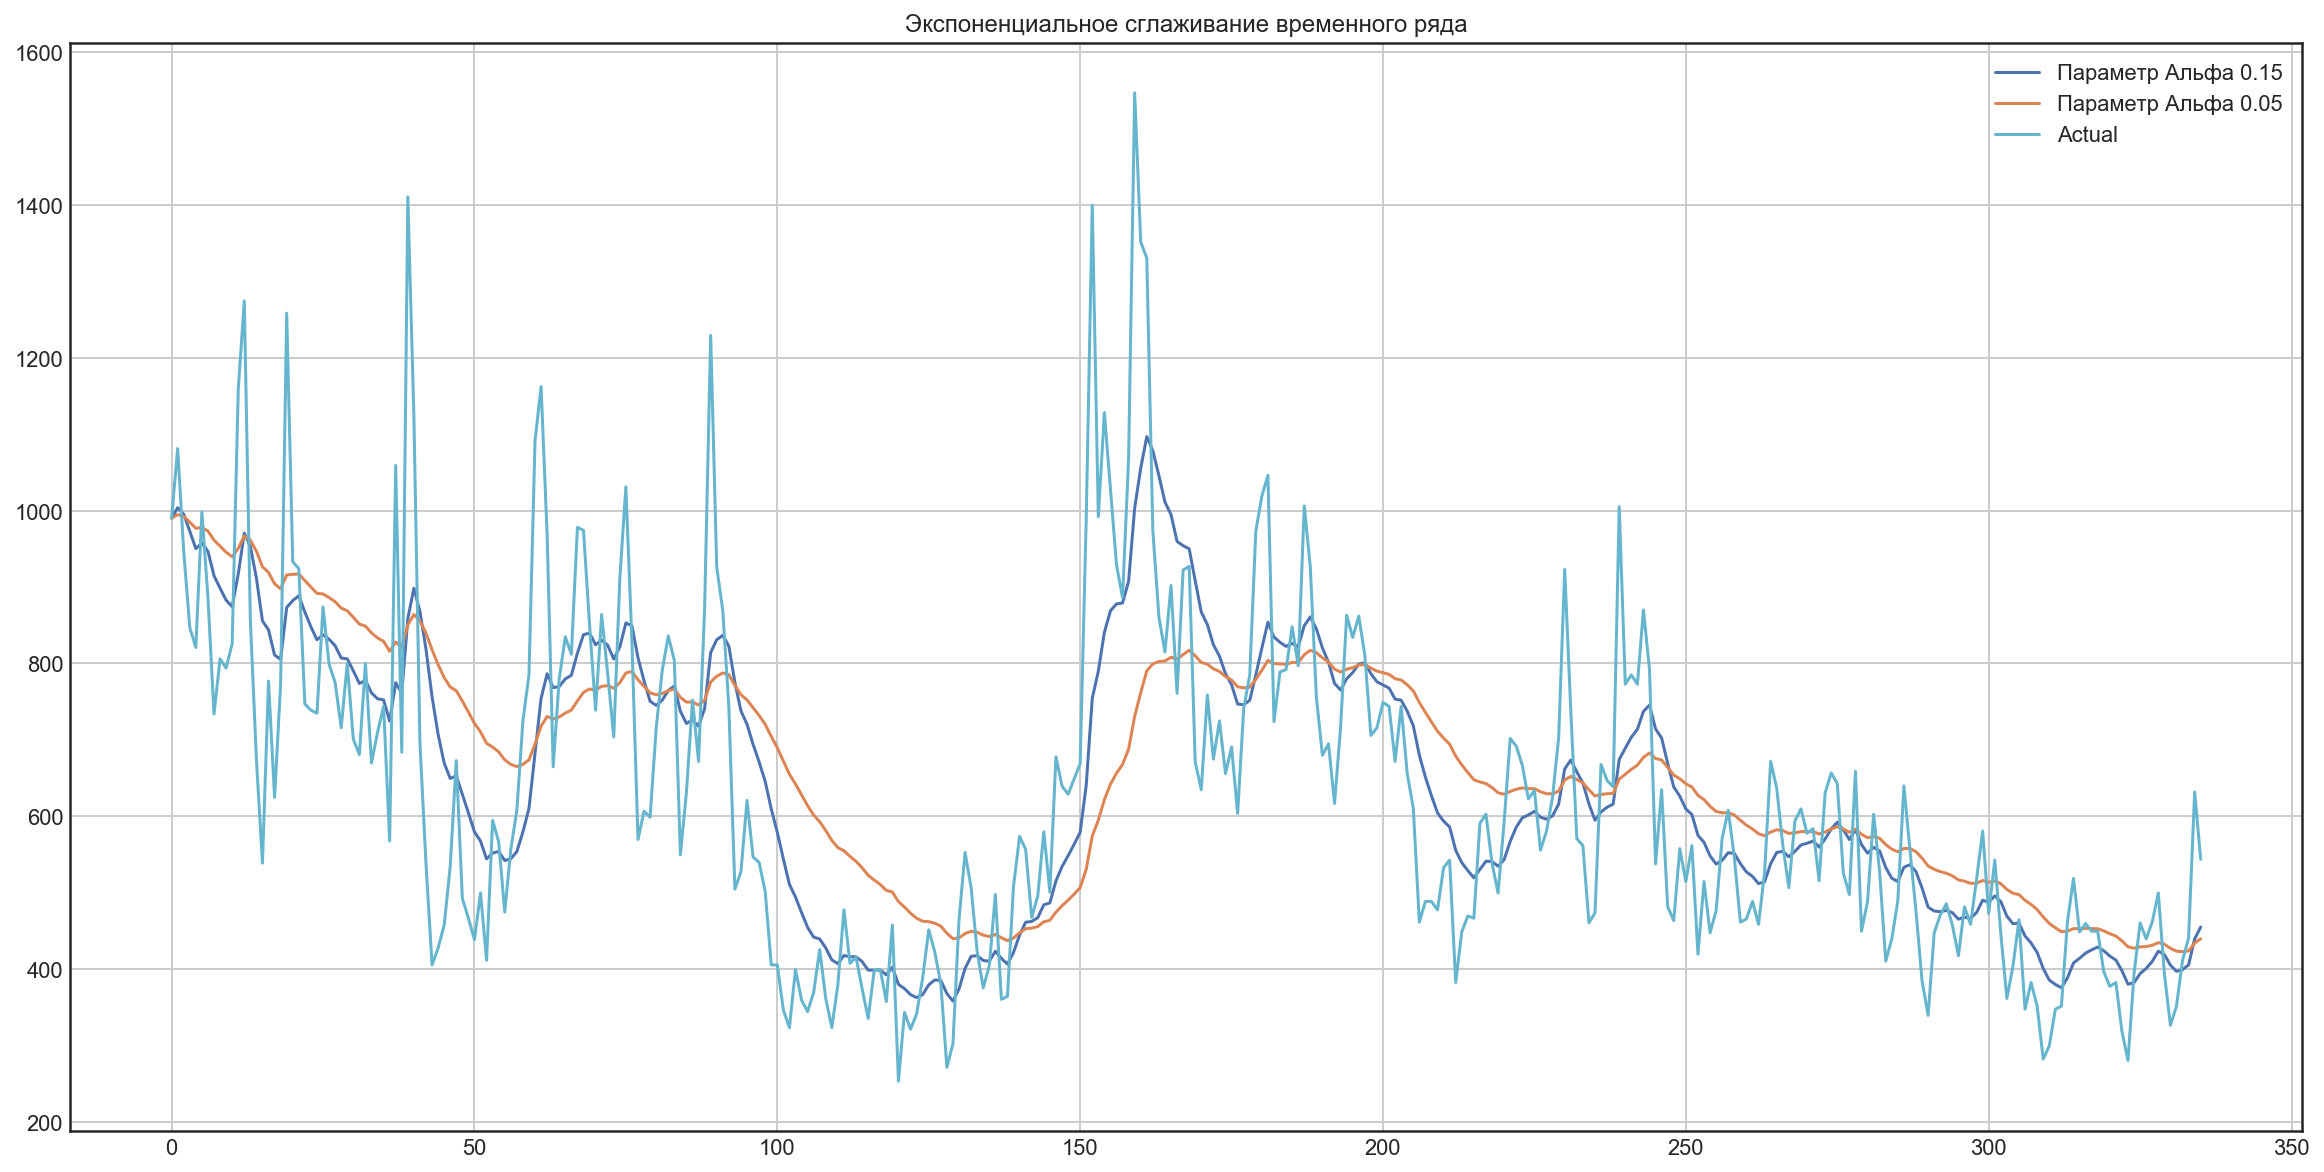

In [49]:
plot_exponential_smoothing(registeredUsers.registeredUsers, [0.15, 0.05])

#### Двойное экспоненциальное сглаживание временного ряда

In [50]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - датасет с временным рядом
        alpha - сглаживающий параметр для уровня
        beta - сглаживающий параметр для тренда
    """
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [51]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """
        Визуализация двойного экспоненциального сглаживания с различными параметрами альфа и бета
        
        series - датасет с временным рядом
        alphas - сглаживающий параметр для уровня
        betas - сглаживающий параметр для тренда
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize = (20, 10))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label = " α {}, β {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc = "best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

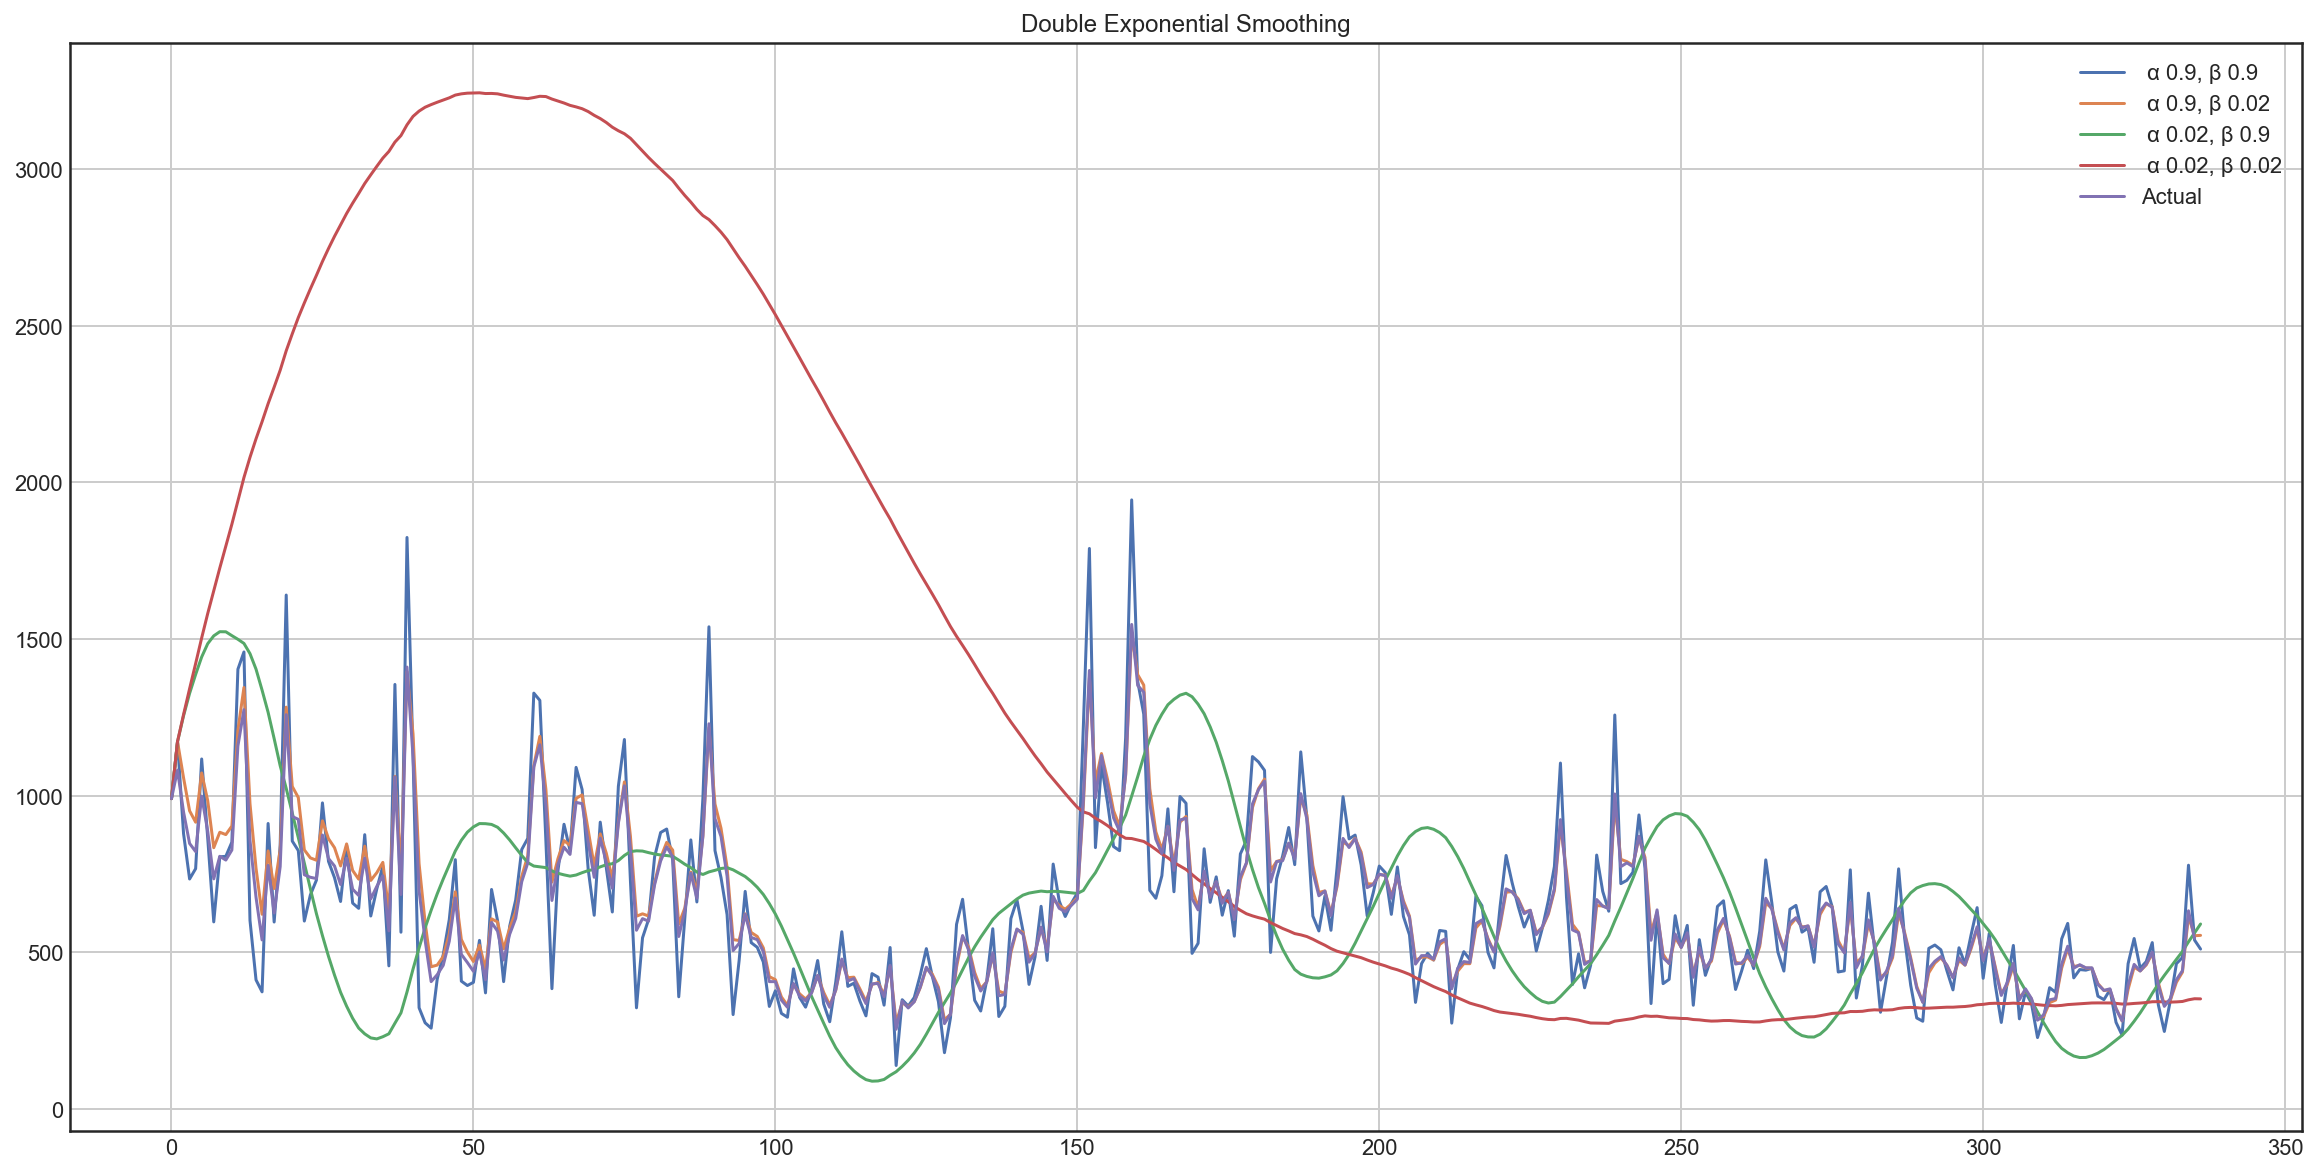

In [52]:
plot_double_exponential_smoothing(registeredUsers.registeredUsers, alphas = [0.9, 0.02], betas = [0.9, 0.02])

### Тройное экспоненциальное сглаживание. Метрика Хольта-Винтерса

In [57]:
class HoltWinters:
    """
        Holt-Winters model with anomalies detection using Brutlag method
        
        series - initial time series
        slen - length of a season
        alpha, beta, gamma - Holt-Winters model coefficients
        n_preds - prediction horizon
        scaling_factor - sets the width of the confidence interval by Brutlag (usually between 2 and 3)
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        summation = 0.0
        for i in range(self.slen):
            summation += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return summation / self.slen
    
    def initial_season_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        
        #Calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen * j : self.slen * j + self.slen]) / float(self.slen))
        
        #Calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals
    
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        seasonals = self.initial_season_components()
        
        for i in range(len(self.series) + self.n_preds):
            #Components initialization
            if i == 0:
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBound.append(self.result[0] +
                                       self.scaling_factor *
                                       self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                       self.scaling_factor *
                                       self.PredictedDeviation[0])
                
                continue
                
            #Predict
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])
                
                #When predicting, we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                
                #Deviation calculated according to Brutlag algorithm
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) + (1 - self.gamma) * self.PredictedDeviation[-1])
                
            self.UpperBound.append(self.result[-1] +
                                   self.scaling_factor *
                                   self.PredictedDeviation[-1])
            
            self.LowerBound.append(self.result[-1] - 
                                   self.scaling_factor *
                                   self.PredictedDeviation[-1])
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

### Кросс-валидация временного ряда

In [68]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_CV_score(params, 
                         series, 
                         loss_function = mean_squared_error, 
                         slen=14):
    """
        Return error of cross-validation
        
        params - vector of parameters for optimization
        series - dataset with time series
        slen - season length for Holt-Winters
    """
    
    #Initialize error array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    #set the number of folds for cross validation
    tscv = TimeSeriesSplit(n_splits = 3)
    
    #Iterate over folds, train model, forecast and calculate error
    for train, test in tscv.split(values):
        
        model = HoltWinters(series = values[train], 
                            slen = slen,
                            alpha = alpha,
                            beta = beta,
                            gamma = gamma,
                            n_preds = len(test))
        
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [69]:
data = registeredUsers.registeredUsers[:]

#Initialize smoothing parameters
x = [0, 0, 0]

#Minimize the loss function
opt = minimize(time_series_CV_score, 
               x0 = x, 
               args = (data, mean_squared_error),
               method = 'TNC', 
               bounds = ((0, 1), (0, 1), (0, 1)))

#Take optimal values
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

#Train model with optimal values
model = HoltWinters(data, 
                    slen = 14,
                    alpha = alpha_final,
                    beta = beta_final, 
                    gamma = gamma_final,
                    n_preds = 31, 
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.07254858708391548 0.008170935406649427 0.0


In [71]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize = (20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBound[:len(series)]] = \
            series.values[series.values<model.LowerBound[:len(series)]]
        anomalies[series.values>model.UpperBound[:len(series)]] = \
            series.values[series.values>model.UpperBound[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBound, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBound, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBound, 
                         y2=model.LowerBound, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBound), ymax=max(model.UpperBound), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    


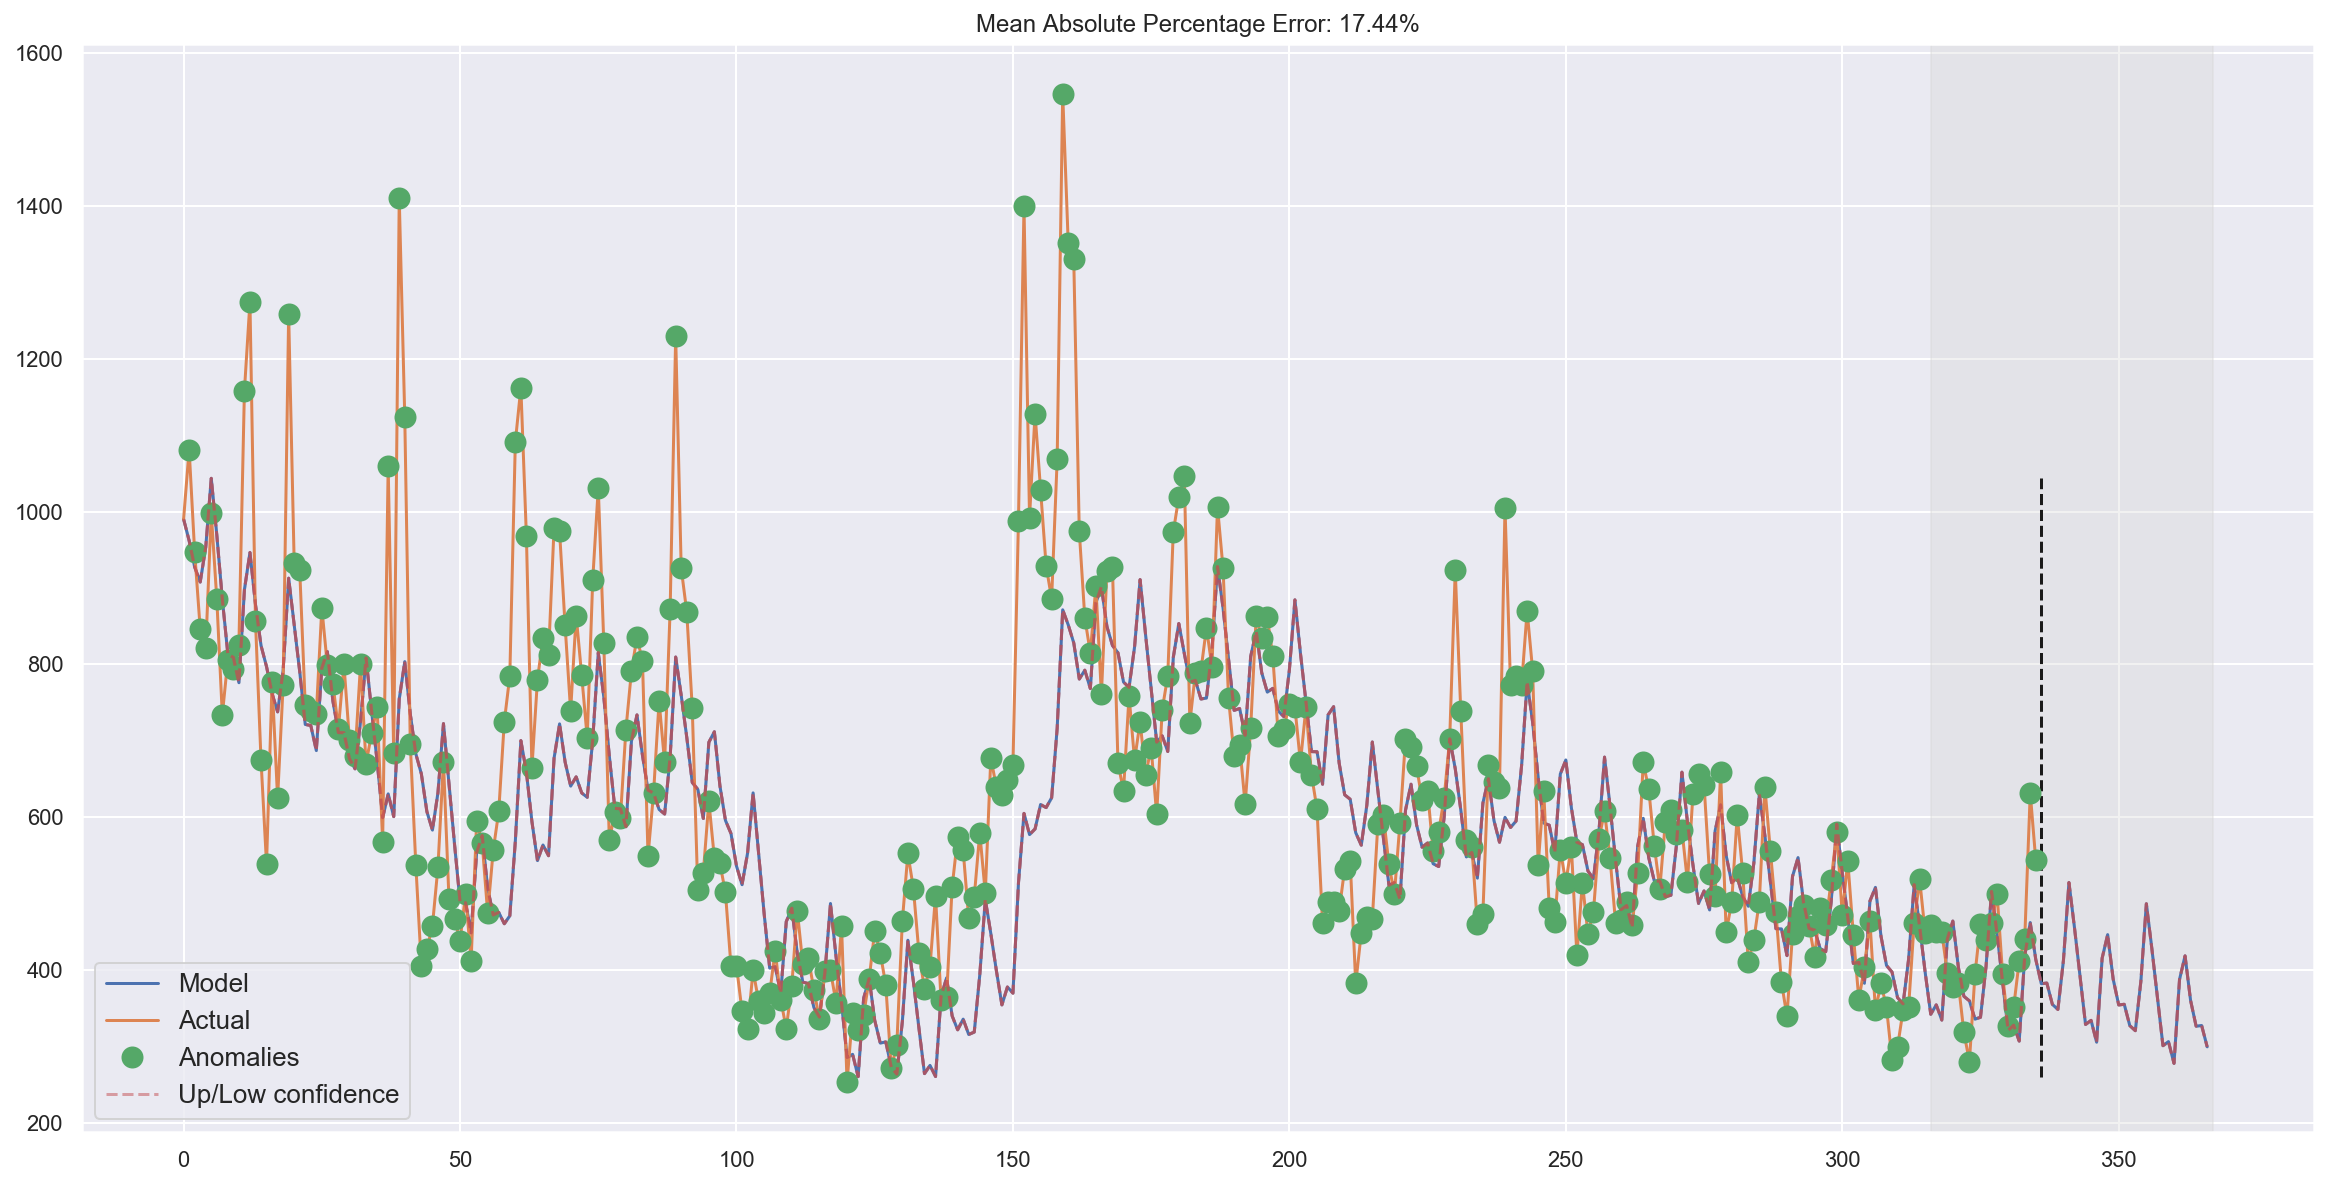

In [72]:
plotHoltWinters(registeredUsers.registeredUsers, plot_intervals=True, plot_anomalies=True)

In [104]:
data = registeredUsers.registeredUsers[:-50]
slen = 11 #30-day seasonality

x = [0, 0, 0]

opt = minimize(time_series_CV_score, 
               x0 = x,
               args = (data, mean_absolute_percentage_error, slen),
               method = 'TNC', 
               bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, 
                    slen = slen,
                    alpha = alpha_final,
                    beta = beta_final,
                    gamma = gamma_final,
                    n_preds = 100,
                    scaling_factor = 3)

0.0014735791937703913 0.044626045517435486 0.0


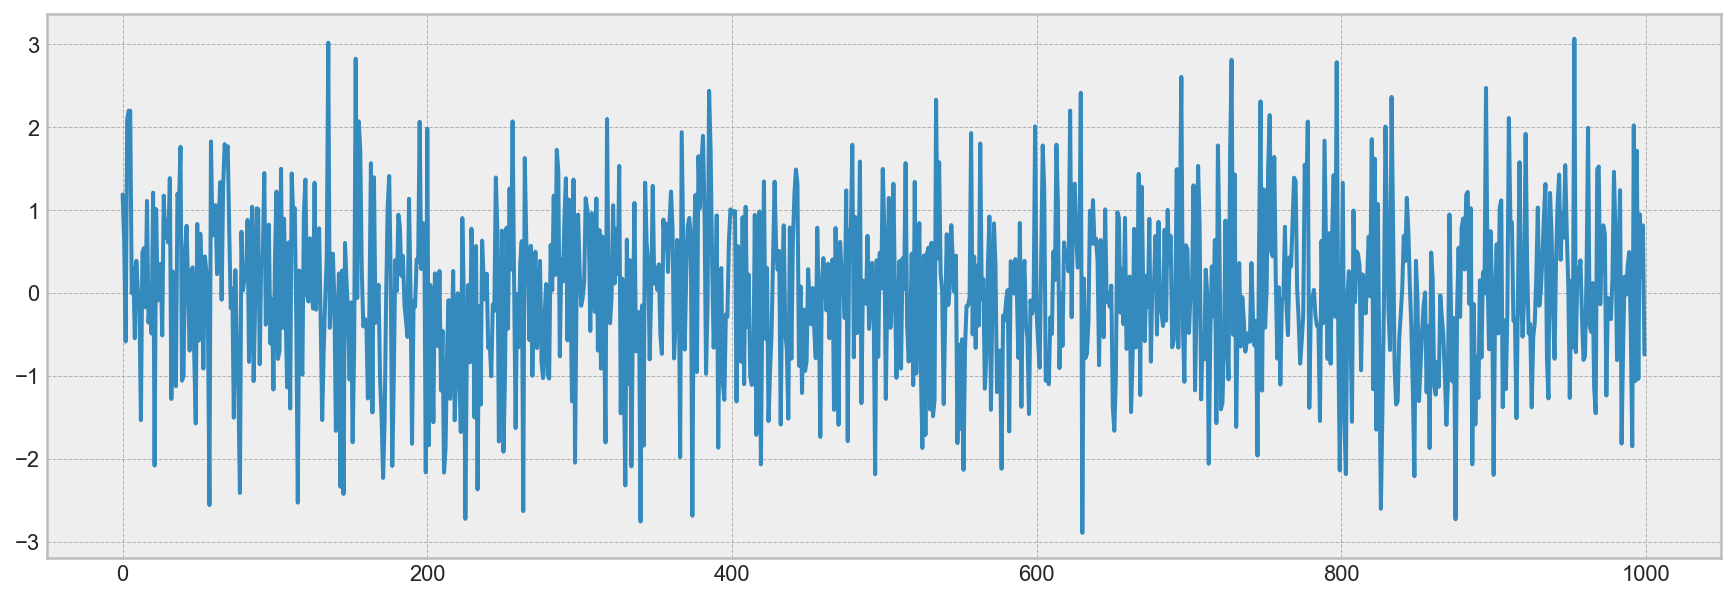

In [108]:
white_noise = np.random.normal(size=1000)

with plt.style.context('bmh'):
    plt.figure(figsize=(15,5))
    plt.plot(white_noise)

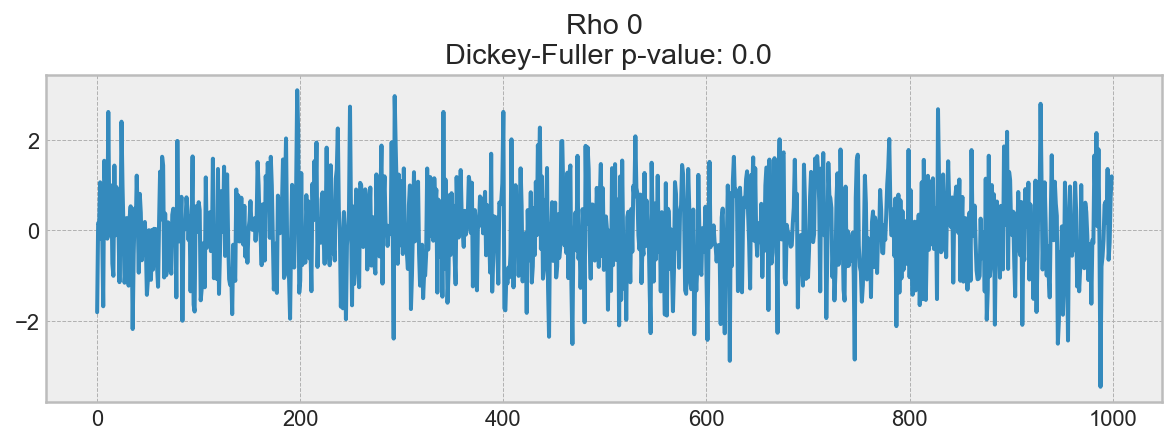

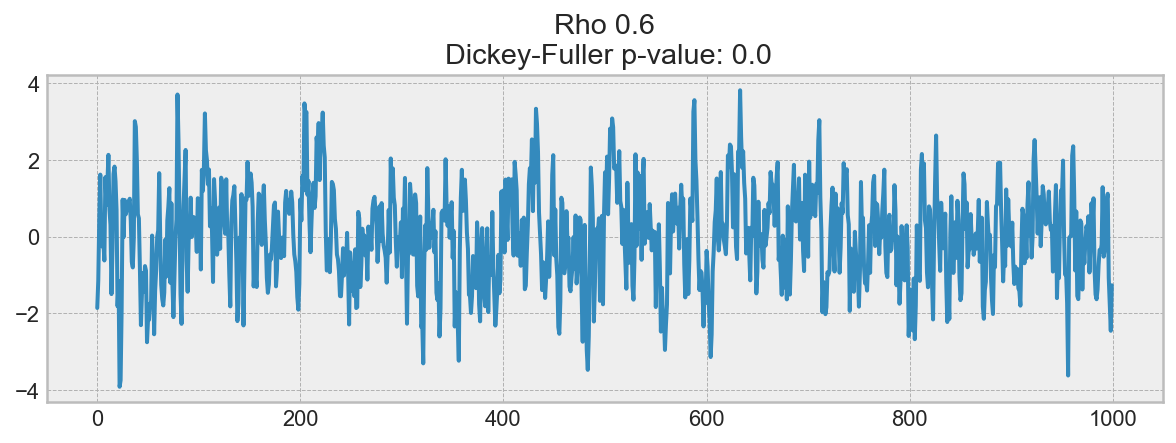

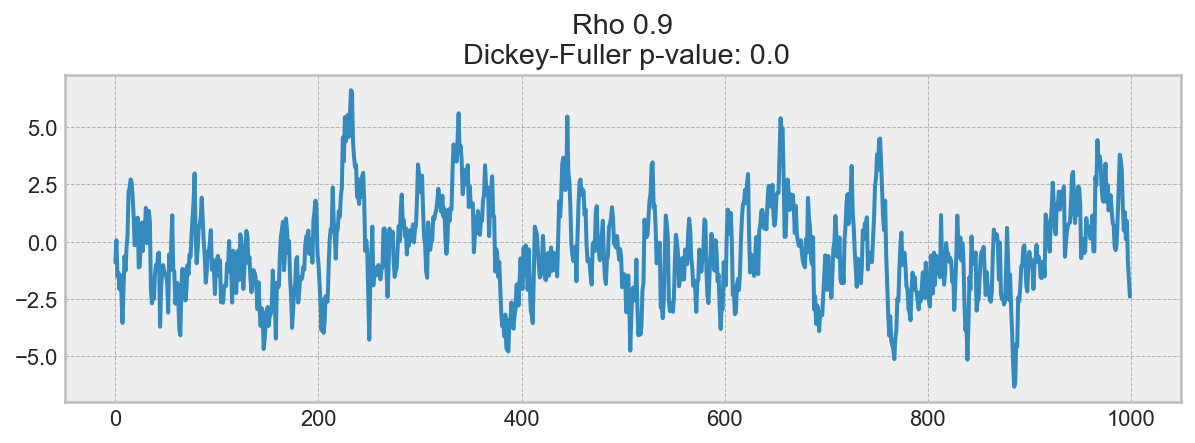

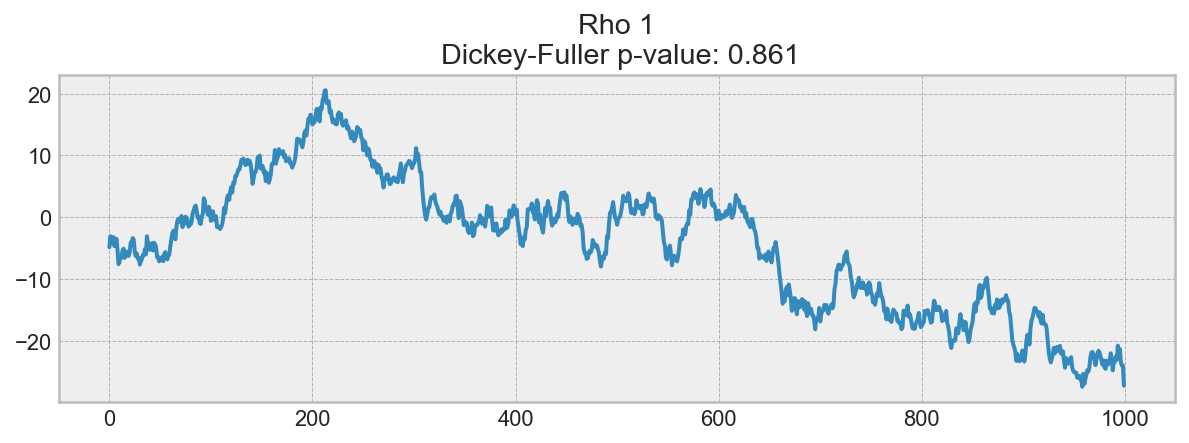

In [109]:

def plot_process(rho, n_samples=1000):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
        
    with plt.style.context('bmh'):
        plt.figure(figsize=(10,3))
        plt.plot(x)
        plt.title('Rho {}\n Dickey-Fuller p-value: {}'.format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plot_process(rho = rho)


In [110]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - time seris
        lags - how many lags to include in ACF, PACF, calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

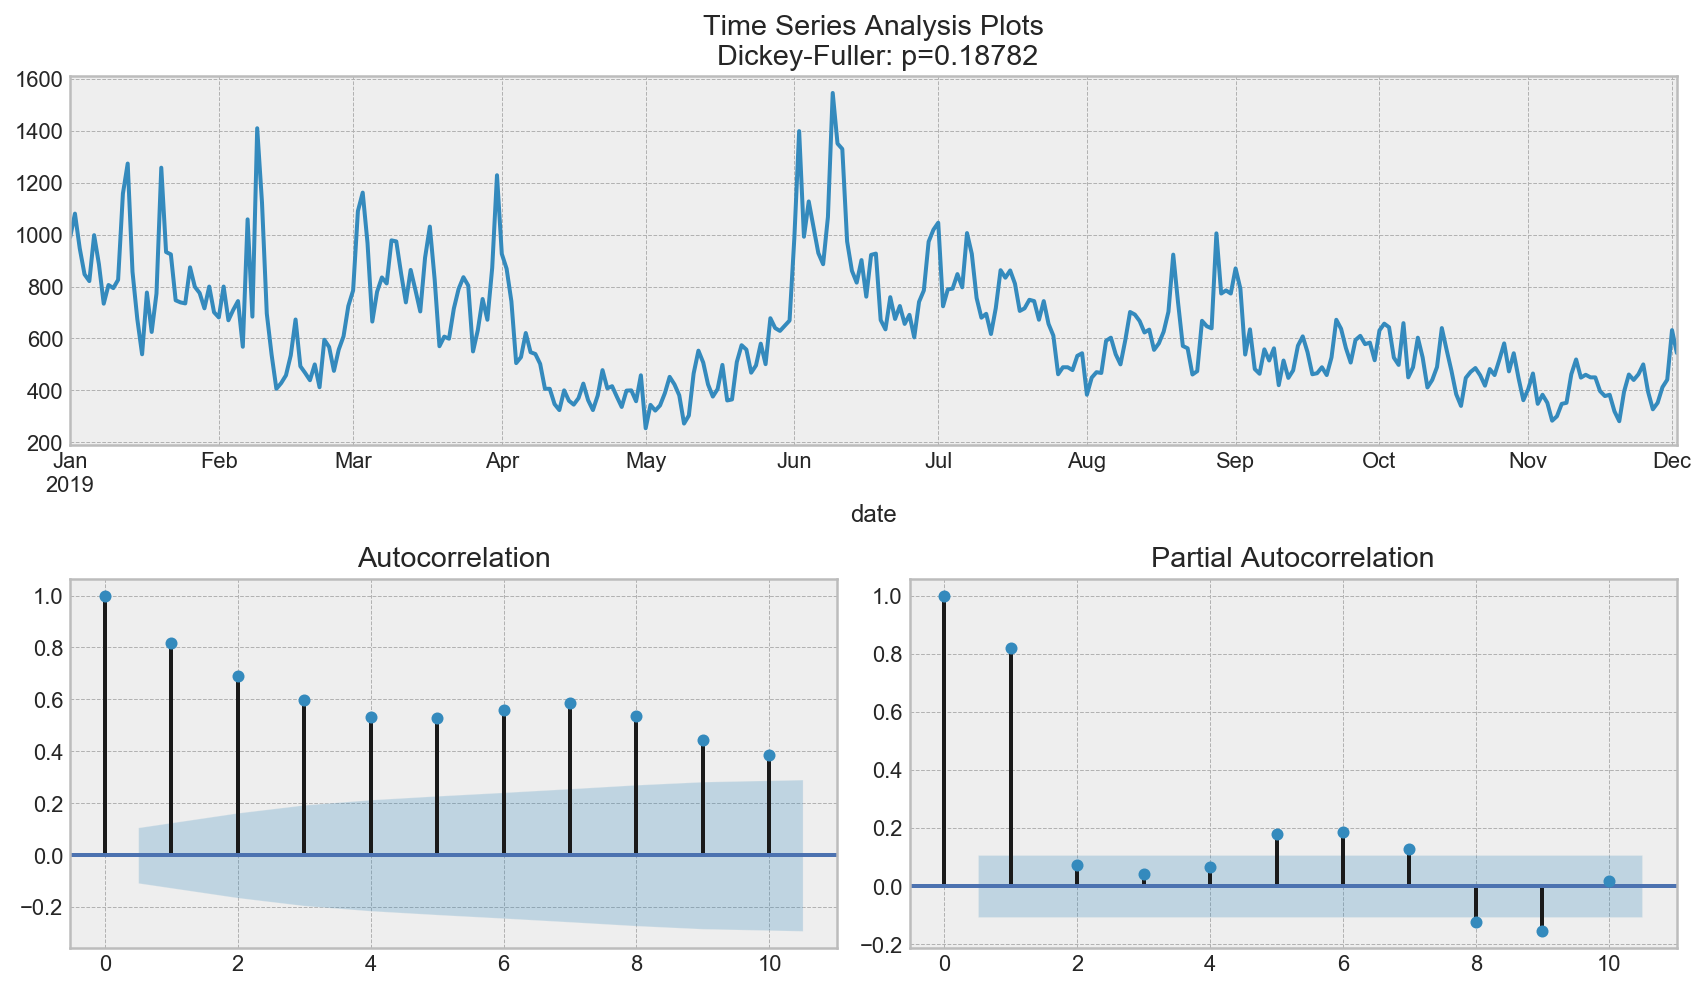

In [114]:
tsplot(registeredUsers.registeredUsers, lags=10)